In [249]:
from cvxpy import *
import numpy as np
import networkx as nx
import scipy.linalg as sla
import mosek
import matplotlib.pyplot as plt
%precision %.2f
np.set_printoptions(precision=2)

[-1.  0.  0.  1.]


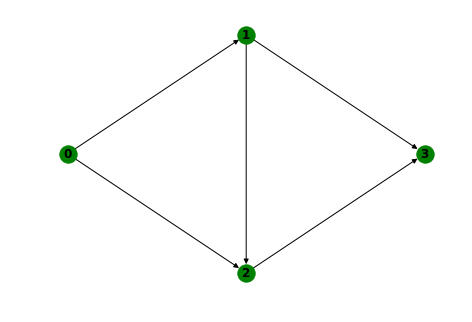

In [265]:
# Graph set up 
edges = [(0,1),(0,2), (1,2), (2,3), (1,3)] ;

wheat = nx.DiGraph(edges);
# Degree/Incidence matrix
E = nx.incidence_matrix(wheat, oriented=True).toarray();
# print(E)
# Number of edges
e = wheat.number_of_edges();
# Number of nodes
v = wheat.number_of_nodes();
#Specify their positions
nodePos = {0: (0,1),
           1: (1,2),
           2: (1,0),
           3: (2,1)}
# Draw graph
nx.draw(wheat,pos=nodePos, node_color='g', edge_color='k', with_labels=True, font_weight='bold')
sourceNode = 0;
sinkNode = 3;
sourceVec = np.zeros((v));
sourceVec[sourceNode] = -1;
sourceVec[sinkNode] = 1;
print(sourceVec)

In [266]:
# Generate routes matrix
routes =  list(nx.all_simple_paths(wheat, source=sourceNode, target=sinkNode));
RouteMat = np.zeros((wheat.number_of_edges(), len(routes)));
for route in range(0,len(routes)):
    curRoute = routes[route];#Route is in nodes
    #Look for the index of corresponding edge
    for edge in range(0,len(curRoute)-1):
        #Unpack edge
        start= curRoute[edge]; end = curRoute[edge+1];
        edgeInd = edges.index((start,end)); #find the edge index in list
        RouteMat[edgeInd,route]= 1;


In [267]:
# Set up Latency function, social cost, 
# wardrop potential cost
# latency function
A = np.diag([1., 0, 0, 1, 0.])
b = np.array([0., 1., 0, 0, 1.])
def latency(x): 
    return A.dot(x) +b;
def P(x): # Wardrop Potential
    xTrans = x.T.dot(A)
    return 0.5*x.T.dot(A).dot(x) + b.T.dot(x);
def Q(x):  # Average Potential
    return x.T.dot(A.dot(x)) + b.T.dot(x);
# wheat.edges()


In [268]:
# Figure out for which mass values does the paradox occur
massIterations = 50;
potComp = np.zeros([3,massIterations]);
newQ = np.zeros([2,massIterations]);
for massInd in range(0,massIterations):
    # Problem data.
    # mass = i;
    mass = 0.1*massInd;
    potComp[0,massInd] = mass;
    print("_________________MASS_________________")
    print(" mass = "+str(mass))
    # Construct the problem.
    #----------------WARDROP EQUILIBRIUM--------------------
    x = Variable(e); 
    z = Variable(len(routes));
    warPot =  b*x + quad_form(x,A)*0.5;
    warObj = Minimize(warPot);
    warConstraints = [0 <= z, 
                      RouteMat*z == x,
                      sum(z) == mass]
    wardrop = Problem(warObj, warConstraints)
    warRes = wardrop.solve(solver=MOSEK)
#     pOpt = x.value;
#     z = sla.inv(RouteMat.T.dot(RouteMat)).dot(RouteMat.T).dot(xOpt)
    print("------Wardrop--------")
    print(z.value)
    print(warPot.value)
    potComp[1,massInd] = warPot.value;
    newQ[0,massInd] = Q(x.value);
    #----------------SOCIAL EQUILIBRIUM---------------------
    y = Variable(e); 
    z = Variable(len(routes));
    socialPot = b*y + quad_form(y,A);
    socailObj = Minimize(socialPot);
    socialConstraints = [0 <= z, 
                         RouteMat*z == y,
                         sum(z) == mass]
    social =Problem(socailObj, socialConstraints) 
    socialRes = social.solve(solver=MOSEK)
    print("------Social--------")
    print(z.value)
    potComp[2,massInd] = socialPot.value;
#     print(result)
    # The optimal value for x is stored in x.value.
#     print x.value
    # The optimal Lagrange multiplier for a constraint
    # is stored in constraint.dual_value.
    # print constraints[0].dual_value

_________________MASS_________________
 mass = 0.0
------Wardrop--------
[[ 0.]
 [ 0.]
 [ 0.]]
0.0
------Social--------
[[ 0.]
 [ 0.]
 [ 0.]]
_________________MASS_________________
 mass = 0.1
------Wardrop--------
[[  1.00e-01]
 [ -5.93e-09]
 [ -5.93e-09]]
0.00999998907713
------Social--------
[[  1.00e-01]
 [  6.32e-10]
 [  6.32e-10]]
_________________MASS_________________
 mass = 0.2
------Wardrop--------
[[  2.00e-01]
 [ -9.29e-10]
 [ -9.29e-10]]
0.0399999984011
------Social--------
[[  2.00e-01]
 [  1.39e-09]
 [  1.39e-09]]
_________________MASS_________________
 mass = 0.3
------Wardrop--------
[[  3.00e-01]
 [ -3.14e-11]
 [ -3.14e-11]]
0.089999999505
------Social--------
[[  3.00e-01]
 [ -9.04e-09]
 [ -9.04e-09]]
_________________MASS_________________
 mass = 0.4
------Wardrop--------
[[  4.00e-01]
 [  1.57e-09]
 [  1.57e-09]]
0.160000000911
------Social--------
[[  4.00e-01]
 [  1.14e-08]
 [  1.14e-08]]
_________________MASS_________________
 mass = 0.5
------Wardrop--------
[[

------Wardrop--------
[[  9.47e-09]
 [  2.20e+00]
 [  2.20e+00]]
9.23999999686
------Social--------
[[  2.36e-08]
 [  2.20e+00]
 [  2.20e+00]]
_________________MASS_________________
 mass = 4.5
------Wardrop--------
[[  8.45e-08]
 [  2.25e+00]
 [  2.25e+00]]
9.56249995583
------Social--------
[[  7.03e-08]
 [  2.25e+00]
 [  2.25e+00]]
_________________MASS_________________
 mass = 4.6
------Wardrop--------
[[  9.88e-08]
 [  2.30e+00]
 [  2.30e+00]]
9.88999990598
------Social--------
[[  2.74e-10]
 [  2.30e+00]
 [  2.30e+00]]
_________________MASS_________________
 mass = 4.7
------Wardrop--------
[[  1.31e-07]
 [  2.35e+00]
 [  2.35e+00]]
10.2225000522
------Social--------
[[  5.65e-10]
 [  2.35e+00]
 [  2.35e+00]]
_________________MASS_________________
 mass = 4.8
------Wardrop--------
[[  1.31e-09]
 [  2.40e+00]
 [  2.40e+00]]
10.5599999971
------Social--------
[[  7.51e-10]
 [  2.40e+00]
 [  2.40e+00]]
_________________MASS_________________
 mass = 4.9
------Wardrop--------
[[  5.34

In [269]:
# Remove an edge and try again
# Graph set up 
edges = [(0,1),(0,2), (2,3), (1,3)] ;
wheat = nx.DiGraph(edges);
# Degree/Incidence matrix
E = nx.incidence_matrix(wheat, oriented=True).toarray();
# print(E)
# Number of edges
e = wheat.number_of_edges();
# Number of nodes
v = wheat.number_of_nodes();

# Generate routes matrix
routes =  list(nx.all_simple_paths(wheat, source=sourceNode, target=sinkNode));
RouteMat = np.zeros((wheat.number_of_edges(), len(routes)));
for route in range(0,len(routes)):
    curRoute = routes[route];#Route is in nodes
    #Look for the index of corresponding edge
    for edge in range(0,len(curRoute)-1):
        #Unpack edge
        start= curRoute[edge]; end = curRoute[edge+1];
        edgeInd = edges.index((start,end)); #find the edge index in list
        RouteMat[edgeInd,route]= 1;
        

        
        
A = np.diag([1., 0, 1, 0.])
b = np.array([0., 1., 0, 1.])
def latency(x): 
    return A.dot(x) +b;
def P(x): # Wardrop Potential
    xTrans = x.T.dot(A)
    return 0.5*x.T.dot(A).dot(x) + b.T.dot(x);
def Q(x):  # Average Potential
    return x.T.dot(A.dot(x)) + b.T.dot(x);



for massInd in range(0,massIterations):
    # Problem data.
    # mass = i;
    mass = 0.1*massInd;
    potComp[0,massInd] = mass;
    print("_________________MASS_________________")
    print(" mass = "+str(mass))
    # Construct the problem.
    #----------------WARDROP EQUILIBRIUM--------------------
    x = Variable(e); 
    z = Variable(len(routes));
    warPot =  b*x + quad_form(x,A)*0.5;#b.T.dot(x)
    warObj = Minimize(warPot);
    warConstraints = [0 <= z, 
                      RouteMat*z == x,
                      sum(z) == mass]
    wardrop = Problem(warObj, warConstraints)
    warRes = wardrop.solve(solver=MOSEK)
#     pOpt = x.value;
#     z = sla.inv(RouteMat.T.dot(RouteMat)).dot(RouteMat.T).dot(xOpt)
    print("------Wardrop--------")
    print(z.value)
    print(warPot.value)
    newQ[1, massInd] = Q(x.value);


_________________MASS_________________
 mass = 0.0
------Wardrop--------
[[ 0.]
 [ 0.]]
0.0
_________________MASS_________________
 mass = 0.1
------Wardrop--------
[[ 0.05]
 [ 0.05]]
0.102499999902
_________________MASS_________________
 mass = 0.2
------Wardrop--------
[[ 0.1]
 [ 0.1]]
0.209999999986
_________________MASS_________________
 mass = 0.3
------Wardrop--------
[[ 0.15]
 [ 0.15]]
0.322499999958
_________________MASS_________________
 mass = 0.4
------Wardrop--------
[[ 0.2]
 [ 0.2]]
0.43999999995
_________________MASS_________________
 mass = 0.5
------Wardrop--------
[[ 0.25]
 [ 0.25]]
0.562499999986
_________________MASS_________________
 mass = 0.6
------Wardrop--------
[[ 0.3]
 [ 0.3]]
0.68999999996
_________________MASS_________________
 mass = 0.7
------Wardrop--------
[[ 0.35]
 [ 0.35]]
0.822499998961
_________________MASS_________________
 mass = 0.8
------Wardrop--------
[[ 0.4]
 [ 0.4]]
0.959999996059
_________________MASS_________________
 mass = 0.9
------Wardr

In [277]:
# Compare social potential and wardrop potential
# plt.figure()
# for i in range(len(potComp[:,0])-1):
#     whichPot = "Wardrop Potential"
#     if(i == 1):
#         whichPot = "Social Potential"
#     plt.plot(potComp[0,:],potComp[i,:],label=(whichPot));

# plt.xlabel('Mass Input')
# plt.ylabel('Potential Value')
# plt.title('Potential Comparison')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

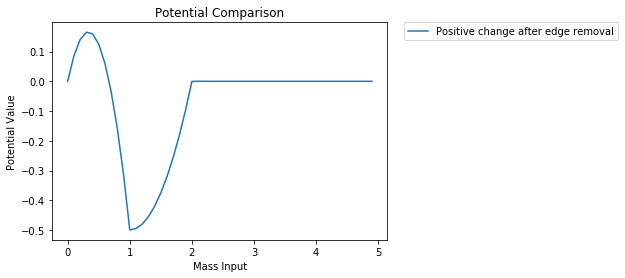

In [278]:
# Compare social potential and wardrop potential
plt.figure()

plt.plot(potComp[0,:],newQ[1,:]- newQ[0,:],label=("Positive change after edge removal"));
# for i in range(len(potComp[:,0])-1):
#     whichPot = "Wardrop Potential"
#     if(i == 0):
#         whichPot = "Wheatstone Social Potential"
#         plt.plot(potComp[0,:],newQ[i,:],label=(whichPot));
#     else:
#         whichPot = "Removed Edge Social Potential"
#         plt.plot(potComp[0,:],newQ[i,:],label=(whichPot));
    
plt.xlabel('Mass Input')
plt.ylabel('Potential Value')
plt.title('Potential Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)